# CO2SYS pH DIC and Alk Sensitivity

---

Now looking to decompose non-temperature effects on pH even further. So we've split into temperature and non-temperature effects using `cbsyst` with fixed DIC, Alk, Salinity and varying temperature. Now I want to vary DIC and Alk and Salinity to look at those effects.

In [1]:
import cbsyst as cb
from scipy.stats import linregress

import numpy as np
import pandas as pd
import xarray as xr

import esmtools as et
import climpred as cp
import caldecpred as project

import matplotlib.pyplot as plt 
%matplotlib inline
import proplot as plot
plot.nbsetup()

Configured ipython notebook.


In [8]:
def load_processed_FOSI(var, annual_means=True, area_weight=True):
    """
    I used NCO's to process the raw 3D output for DIC/ALK from Steve's FOSI reconstruction.
    
    ncks -v VAR -d z_t,0 in.nc out.nc
    """
    filepath = '/glade/scratch/rbrady/CalCS_decadal_prediction/FOSI_output/'
    if var == 'SST':
        filename = f'{filepath}/SST.194801-201712.nc'
    else:
        filename = f'{filepath}/{var}surf.194801-201712.nc'
    ds = xr.open_dataset(filename, decode_times=False)
    ds = ds.squeeze()[var]
    ds['time'] = pd.date_range('1948-01', '2018-01', freq='M')
    if annual_means:
        ds = ds.groupby('time.year').mean('time').rename({'year': 'time'})
    # Mask LME
    mask = project.IO.load_mask()
    ds = ds.where(mask==3)
    # Area-weight
    if area_weight:
        ds = et.stats.xr_area_weight(ds, area_coord='TAREA')
    ds.name = var
    return ds

## Find ranges for each variable

---

This will be used to compute the sensitivity.

**DIC range**: 1760 - 2080

**ALK range**: 1950 - 2350

**SALT range**: 28.5 - 35.5

**SST range**: 7 - 31

In [21]:
DIC = load_processed_FOSI('DIC', area_weight=False, annual_means=False)
ALK = load_processed_FOSI('ALK', area_weight=False, annual_means=False)
SALT = load_processed_FOSI('SALT', area_weight=False, annual_means=False)
SST = load_processed_FOSI('SST', area_weight=False, annual_means=False)

In [22]:
for variable in ['DIC', 'ALK', 'SALT', 'SST']:
    print(f'minimum {variable}: {eval(variable).min().values}')
    print(f'maximum {variable}: {eval(variable).max().values}')

minimum DIC: 1760.8525390625
maximum DIC: 2076.8642578125
minimum ALK: 1958.670166015625
maximum ALK: 2349.9990234375
minimum SALT: 28.85431480407715
maximum SALT: 35.1247673034668
minimum SST: 7.0546040534973145
maximum SST: 30.658849716186523


## Load in area-weighted annual means

---

**DIC mean**: 1998.3 umol

**ALK mean**: 2247.5 umol

**SALT mean**: 33.5

**SST mean**: 17.7

In [28]:
DIC = load_processed_FOSI('DIC')
ALK = load_processed_FOSI('ALK')
SALT = load_processed_FOSI('SALT')
SST = load_processed_FOSI('SST')

/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Summing over nlat
Summing over nlon


/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Summing over nlat
Summing over nlon


/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Summing over nlat
Summing over nlon


/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Summing over nlat
Summing over nlon


In [29]:
for variable in ['DIC', 'ALK', 'SALT', 'SST']:
    print(f'{variable} mean: {eval(variable).mean()}')

DIC mean: <xarray.DataArray 'DIC' ()>
array(1998.275596)
Coordinates:
    z_t      float32 500.0
ALK mean: <xarray.DataArray 'ALK' ()>
array(2247.461875)
Coordinates:
    z_t      float32 500.0
SALT mean: <xarray.DataArray 'SALT' ()>
array(33.500424)
Coordinates:
    z_t      float32 500.0
SST mean: <xarray.DataArray 'SST' ()>
array(17.66138)
Coordinates:
    z_t      float32 500.0


In [35]:
meanDIC = 1998.3
meanALK = 2247.5
meanSSS = 33.5
meanSST = 17.7

## Find Sensitivity via CO2SYS

---

temperature sensitivity notebook proves that monthly averages, time-dependent averages, grid cell averages barely effect dpH/dX so just going to do this for area-weighted annual means.

In [114]:
def sensitivity_plot(var_range, pH, m, vals, variable,
                     xlevel=None, ylevel=None):
    """
    var_range: x-axis of unfixed variable
    pH: pH from CO2SYS.
    m: slope
    vals: linear fit of values
    variable: string of variable name
    xlevel: x value to put slope label on
    """
    plot.rc.small = 12
    plot.rc.large = 14
    plot.rc['figure.facecolor'] = 'w'

    f, ax = plot.subplots(bottomlegend=True)
    ax.scatter(var_range, pH, color='k', s=2)
    ax.plot(var_range, vals, '--', color='r', linewidth=2, 
            label='linear approximation')
    ax.format(ylabel='pH',
              xlabel=f'{variable} [mmol/m3]',
              title=f'dpH/d{variable}')
    if xlevel is not None:
        ax.text(xlevel, ylevel, f'slope: {np.round(m, 5)}')

In [73]:
epsilon=1e-14 # for np.arange

### dpH/dDIC

---

DIC sensitivity.

In [115]:
# actual range of CalCS DIC to compute sensitivity over.
DIC_range = np.arange(1760, 2080+epsilon, 1)

In [116]:
pHtot = cb.Csys(DIC=DIC_range, TA=meanALK, S_in=meanSSS, T_in=meanSST)['pHtot']

In [117]:
m, b, r, p, err = linregress(DIC_range, pHtot)
vals = m*DIC_range + b

In [118]:
print(f'dpH/dDIC: {np.round(m, 5)}/mmol/m3')

dpH/dDIC: -0.0017/mmol/m3


Adjusting gridspec.
Resetting rcparams.


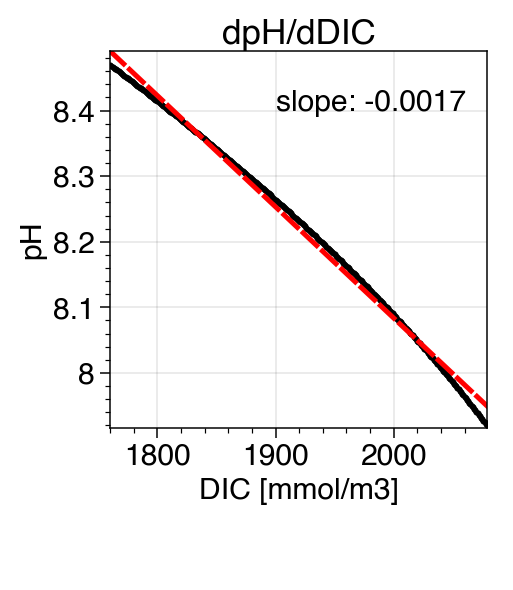

In [119]:
sensitivity_plot(DIC_range, pHtot, m, vals, 'DIC', 1900, 8.4)

### dpH/dAlk

In [120]:
# actual range of CalCS Alk to compute sensitivity over.
ALK_range = np.arange(1950, 2350+epsilon, 1)

In [121]:
pHtot = cb.Csys(DIC=meanDIC, TA=ALK_range, S_in=meanSSS, T_in=meanSST)['pHtot']

In [122]:
m, b, r, p, err = linregress(ALK_range, pHtot)
vals = m*ALK_range + b

In [123]:
print(f'dpH/dALK: {np.round(m, 5)}/meq/m3')

dpH/dALK: 0.00251/mmol/m3


Adjusting gridspec.
Resetting rcparams.


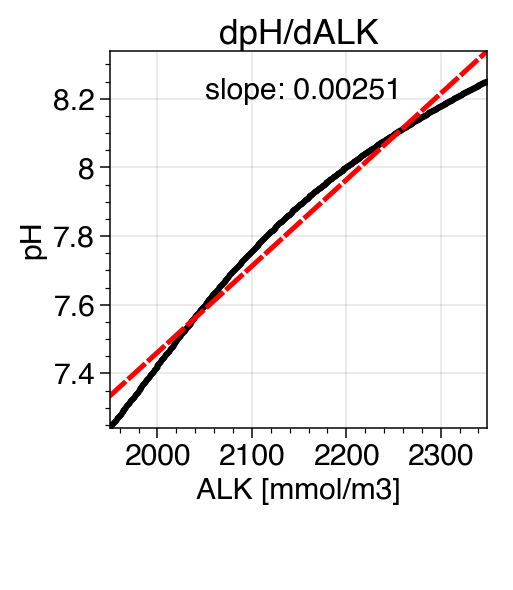

In [125]:
sensitivity_plot(ALK_range, pHtot, m, vals, 'ALK',
                 2050, 8.2)

### dpH/dSSS

In [126]:
SALT_range = np.arange(28.5, 35.5+epsilon, 0.1)

In [127]:
pHtot = cb.Csys(DIC=meanDIC, TA=meanALK, S_in=SALT_range, T_in=meanSST)['pHtot']

In [132]:
m, b, r, p, err = linregress(SALT_range, pHtot)
vals = m*SALT_range + b

In [133]:
print(f'dpH/dSSS: {np.round(m, 5)}/PSU')

dpH/dSSS: -0.01342/PSU


Adjusting gridspec.
Resetting rcparams.


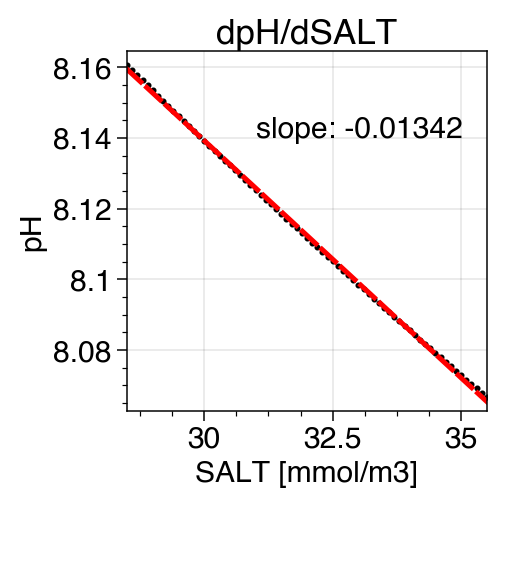

In [138]:
sensitivity_plot(SALT_range, pHtot, m, vals, 'SALT',
                 31, 8.14)